In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('indian')
from nltk.corpus import indian
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package indian to /root/nltk_data...
[nltk_data]   Unzipping corpora/indian.zip.


In [ ]:
tweet_df = pd.read_csv('/content/Hate Speec data in roman - Sheet1.csv')

In [ ]:
tweet_df.head()

,tweet (string),label (class label)
0,"""bhaunk bhaunk ke pagal ho jaata ab tak....""",0 (Abusive/Offensive)
1,"""shivsaina nam mulla saina rakh hijra uddhav t...",0 (Abusive/Offensive)
2,"""there are some yahodi daboo like imran chore ...",0 (Abusive/Offensive)
3,"""chutiye ye hunduism ni he islam he , isme koi...",0 (Abusive/Offensive)
4,"""han g rakhail e awal kiya bak rai hai. kisay ...",0 (Abusive/Offensive)


In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   tweet (string)       200 non-null    object
 1   label (class label)  200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [ ]:
tweet_df.shape

(200, 2)

In [ ]:
print(tweet_df['tweet (string)'].iloc[0], "\n")
print(tweet_df['tweet (string)'].iloc[1], "\n")
print(tweet_df['tweet (string)'].iloc[2], "\n")
print(tweet_df['tweet (string)'].iloc[3], "\n")
print(tweet_df['tweet (string)'].iloc[4], "\n")

"bhaunk bhaunk ke pagal ho jaata ab tak...." 

"shivsaina nam mulla saina rakh hijra uddhav thackeray" 

"there are some yahodi daboo like imran chore zakat khore" 

"chutiye ye hunduism ni he islam he , isme koi kisi muslim ko ni maarta gashti ke bache" 

"han g rakhail e awal kiya bak rai hai. kisay ahmaq kah rai hai dali. tera baap ho ga ahmaq ghasti bosri ki dali" 



In [ ]:
tweet_df = tweet_df.drop_duplicates('tweet (string)')

In [ ]:
tweet_df.shape

(200, 2)

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatizing(data) :
  tweet = [lemmatizer.lemmatize(word) for word in data]
  return data

In [ ]:
tweet_df['tweet (string)'] = tweet_df['tweet (string)'].apply(lambda x:lemmatizing(x))

In [ ]:
tweet_df.head()

,tweet (string),label (class label)
0,"""bhaunk bhaunk ke pagal ho jaata ab tak....""",0 (Abusive/Offensive)
1,"""shivsaina nam mulla saina rakh hijra uddhav t...",0 (Abusive/Offensive)
2,"""there are some yahodi daboo like imran chore ...",0 (Abusive/Offensive)
3,"""chutiye ye hunduism ni he islam he , isme koi...",0 (Abusive/Offensive)
4,"""han g rakhail e awal kiya bak rai hai. kisay ...",0 (Abusive/Offensive)


<Axes: xlabel='label (class label)', ylabel='count'>

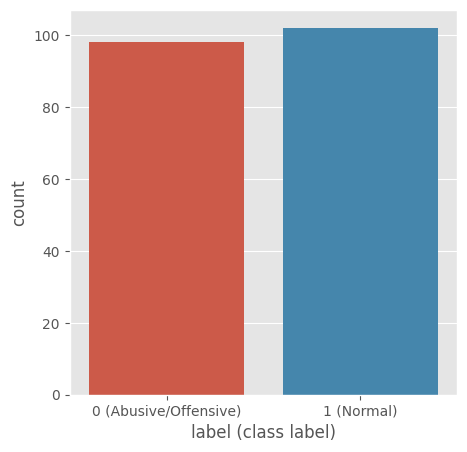

In [ ]:
fig = plt.figure(figsize = (5,5))
sns.countplot( x = 'label (class label)', data = tweet_df)

Text(0.5, 1.0, 'Distribution of Hate and Non-Hate')

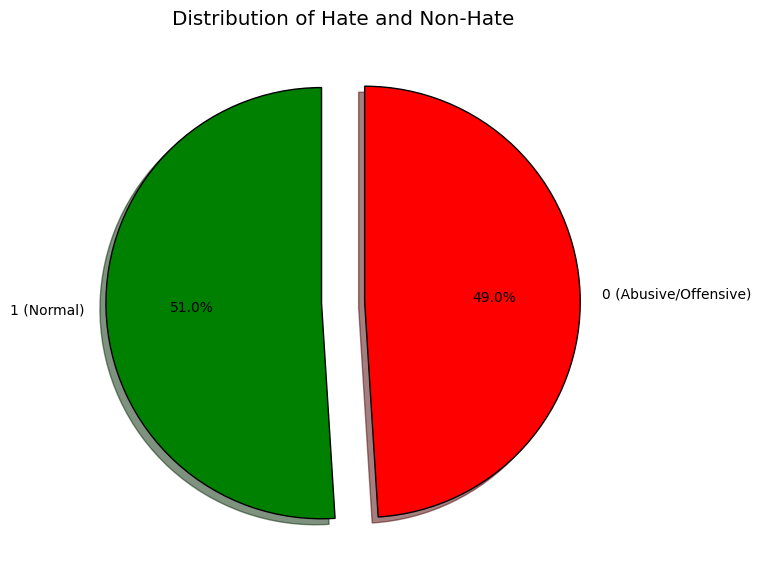

In [ ]:
fig = plt.figure(figsize = (7,7))
colors = ("green", "red")
wp = {'linewidth':1,'edgecolor':"black"}
tags = tweet_df['label (class label)'].value_counts()
explode = (0.1,0.1)
tags.plot(kind = 'pie', autopct = '%1.1f%%', shadow = True, colors = colors, startangle = 90, wedgeprops = wp, explode = explode, label = '')
plt.title("Distribution of Hate and Non-Hate")

In [ ]:
tweet_df = tweet_df.rename(columns={'tweet (string)': 'tweet', 'label (class label)': 'label'})

In [ ]:
tweet_df.head()

,tweet,label
0,"""bhaunk bhaunk ke pagal ho jaata ab tak....""",0 (Abusive/Offensive)
1,"""shivsaina nam mulla saina rakh hijra uddhav t...",0 (Abusive/Offensive)
2,"""there are some yahodi daboo like imran chore ...",0 (Abusive/Offensive)
3,"""chutiye ye hunduism ni he islam he , isme koi...",0 (Abusive/Offensive)
4,"""han g rakhail e awal kiya bak rai hai. kisay ...",0 (Abusive/Offensive)


In [ ]:
roman_urdu_stopwords = set([
    "b","bhai","hai"
    "ho", "kya", "hain", "par", "le", "liye", "bhi", "aur", "thay", "rahe", "hota", "hoti", "hote", "hoon",
    "hai", "hai", "ka", "ki", "ke", "ko", "mein", "me", "se", "ek", "sab", "us", "in", "ho", "ja", "jaise",
    "aisa", "aisi", "ab", "na", "jab", "kuch", "ye", "wale", "wali", "ho", "hi", "mujhe", "mujhse", "tum",
    "tumhe", "tumse", "ap", "apko", "apne", "hum", "humne", "humein", "unko", "unki", "unka", "fir", "phir",
    "jabki", "kisi", "kisi", "kis", "kiska", "kisne", "iske", "uski", "uska", "usne", "mere", "meri", "mera",
    "main", "maine", "tu", "tera", "teri", "tere", "aap", "aapko", "aapki", "aapke", "wo", "woh", "woh",
    "uss", "usne", "uski", "uska", "unhone", "kar", "karta", "karti", "karte", "karne", "karne", "karne",
    "ho", "ho", "ho", "hi", "hui", "huye", "haan", "han", "hoga", "hogi", "honge", "haath", "baar", "dil",
    "duniya", "raat", "din", "waqt", "sabse", "sabhi", "tarah", "tarah", "tarah", "raha", "rahi", "rahe",
    "rahe", "rakhna", "rakhne", "rakhne", "karna", "karne", "karte", "karne", "karne", "kiya", "karte", "karta",
    "karti", "karna", "karna", "abhi", "bad", "baat", "baad", "hamesha", "kal", "phela", "pheli", "phelay", "sabse", "sath", "bhar", "bina",
    "dusra", "dusri", "dusre", "isliye", "itna", "itni", "itne", "jaldi", "kaafi", "kahi", "kahi", "kaise",
    "kuchh", "kuchh", "kuchh", "kuchh", "kyun", "lag", "lag", "lag", "lag", "lag", "lag", "lag", "laga", "lagi",
    "lage", "lage", "lage", "lage", "lage", "lage", "lage", "liya", "liya", "liya", "liya", "main", "main",
    "main", "main", "mil", "mil", "mil", "mil", "mujh", "mujh", "mujh", "mujh", "naam", "naam", "naam", "naam",
    "paisa", "paisa", "paisa", "paisa", "pehle", "pehli", "pehlay", "pehlay", "shayad", "shayad", "shayad", "shayad",
    "tara", "tari", "taray", "tere", "tere", "tere", "thay", "thi", "thi", "thi", "thi", "thi", "thi", "thi",
    "thi", "thi","ho", "kya", "hain", "par", "le", "liye", "bhi", "aur", "thay", "rahe", "hota", "hoti", "hote", "hoon",
    "hai", "hai", "ka", "ki", "ke", "ko", "mein", "me", "se", "ek", "sab", "us", "in", "ho", "ja", "jaise",
    "aisa", "aisi", "ab", "na", "jab", "kuch", "ye", "wale", "wali", "ho", "hi", "mujhe", "mujhse", "tum",
    "tumhe", "tumse", "ap", "apko", "apne", "hum", "humne", "humein", "unko", "unki", "unka", "fir", "phir",
    "jabki", "kisi", "kisi", "kis", "kiska", "kisne", "iske", "uski", "uska", "usne", "mere", "meri", "mera",
    "main", "maine", "tu", "tera", "teri", "tere", "aap", "aapko", "aapki", "aapke", "wo", "woh", "woh",
    "uss", "usne", "uski", "uska", "unhone", "kar", "karta", "karti", "karte", "karne", "karne", "karne",
    "ho", "ho", "ho", "hi", "hui", "huye", "haan", "han", "hoga", "hogi", "honge", "haath", "baar", "dil",
    "duniya", "raat", "din", "waqt", "sabse", "sabhi", "tarah", "tarah", "tarah", "raha", "rahi", "rahe",
    "rahe", "rakhna", "rakhne", "rakhne", "karna", "karne", "karte", "karne", "karne", "kiya", "karte", "karta",
    "karti", "karna", "karna", "kisi","se","nhi","acha","sirf","nhi","nahi","hai","koi","ai", "ayi", "hy", "hai", "main", "ki", "tha", "koi", "ko", "sy", "woh",
        "bhi", "aur", "wo", "yeh", "rha", "hota", "ho", "ga", "ka", "le", "lye",
        "kr", "kar", "lye", "liye", "hotay", "waisay", "gya", "gaya", "kch", "ab",
        "thy", "thay", "houn", "hain", "han", "to", "is", "hi", "jo", "kya", "thi",
        "se", "pe", "phr", "wala", "waisay", "us", "na", "ny", "hun", "rha", "raha",
        "ja", "rahay", "abi", "uski", "ne", "haan", "acha", "nai", "sent", "photo",
        "you", "kafi", "gai", "rhy", "kuch", "jata", "aye", "ya", "dono", "hoa",
        "aese", "de", "wohi", "jati", "jb", "krta", "lg", "rahi", "hui", "karna",
        "krna", "gi", "hova", "yehi", "jana", "jye", "chal", "mil", "tu", "hum", "par",
        "hay", "kis", "sb", "gy", "dain", "krny", "tou","na","tha","kon","pta","pata","kia","kiya",
    "hai","habhai","hain","kon","pta","kia","aap","hai","bhai","ha","bhai","habhai","aap",
  "aao","aao","aai","aaien","aye","aaj","aajao","aajien","aajiye","aajao","aajkal","aap","aapka","aapka","aapki","aya","ab","abhi","is","istrh","iska","iski","iskay","isi","isy","alag","un","inka","inki","inkay","inhon","inhain","inhain","aur","uncha","unchi","unchay","upar","apna","apni","apnay","aksar","agar","agarcha","aham","baien","bar","baray","bahar","baham","bazaria","bs","bazahir","bad","baghair","bilashuba","band","bohat","bhi","bashter","beshak","beshak","taham","tb","tujh","tujhey","tr","trien","tadad","tlak","tum","tamam","tumko","tumhara","tumhari","tumharay","tumhain","tumhara","tumhari","tumharay","tumhain","tou","tak","tha","thi","thien","thay","tesra","tesri","tesray","jien","jata","jati","jatay","jana","janay","jaye","jab","jabhi","jabhi","jabky","jo","jahan","jesa","jesaky","jesi","jesay","khud","dien","darmiyan","dafa","do","door","doran","dusra","dusri","dusray","dono","di","diya","dena","deni","denay","dekha","dekho","dekhi","dekhain","dy","rakh","rakha","rakhi","rakhien","rakhy","reh","raha","rahi","rahain","rahay","zayada","sath","sara","sari","sary","sab","sabhi","sabhi","sakta","sakti","saktain","saktay","sawa","sy","shayad","shuda","sahih","sirf","tarah","taraf","ghalat","ghair","liye","la","lazmi","lo","laga","lagi","lagien","lagay","li","liya","lena","leni","lenay","lekin","liye","liye","la","mujh","mujhko","mujhey","martabah","mazeed","mushtamil","mil","mila","milo","mili","milay","maghar","mera","meri","meray","main","na","nahin","nah","nahin","necha","nechi","nechay","nay","wa","wala","walon","wali","waly","woh","wahan","wahi","wain","pas","par","para","paray","pari","pora","pori","poray","phir","phiro","phiri","phiray","pehla","pehli","pehlay","chaha","chahta","chahti","chahti","chahiye","chahiye","chuka","chuki","chukain","chukay","ka","kab","kabhi","kitna","kar","karty","karna","karni","karnyka","karnyki","karnyky","karnay","karo","karwana","karain","karaingy","kis","kesi","kal","kam","kami","ko","koi","kon","kuch","keh","kaha","kahan","kehta","kehti","kehty","kehna","kehni","kehny","kaho","kahon","kahain","kahay","ki","kya","kijiye","kijiye","kaysath","kesay","kyliye","kyliye","kyon","kay","ga","hogi","hogi","gain","gaye","gi","gaya","ga","han","hr","hum","hamara","hamari","hamary","hamain","ho","hoey","hoa","hona","honga","hongi","hongy","honi","hony","hochuka","hochuki","hogi","hoga","hogi","hogaya","hogy","hogy","hon","hoey","hi","hain","hay","yon","yeh","yahan","hui"
])

In [ ]:
# Filter non-hate tweets
non_hate_tweets = tweet_df[tweet_df.label == '1 (Normal)']
non_hate_tweets.head()

,tweet,label
6,""" hum kisi se km nhi""",1 (Normal)
7,"""aurat bhatak sakri hy kbi “maa” ni bhatakti ....",1 (Normal)
10,""" with due respect sir kya aurat march se ye c...",1 (Normal)
15,""" 😂😂😂😂😂😂 chal ja tujhy maaf kia""",1 (Normal)
16,"""agr ap chahtay hn k log ap ko acha kahean to ...",1 (Normal)


In [ ]:
def remove_stop_nonHate(x):
    return " ".join([word for word in str(x).split() if word not in roman_urdu_stopwords])

non_hate_tweets['tweet'] = non_hate_tweets['tweet'].apply(lambda x : remove_stop_nonHate(x))


<ipython-input-19-a259b585d144>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_hate_tweets['tweet'] = non_hate_tweets['tweet'].apply(lambda x : remove_stop_nonHate(x))


In [ ]:
# Apply stopword removal to the entire 'tweet' column
tweet_df['tweet'] = tweet_df['tweet'].apply(remove_stop_nonHate)

In [ ]:
# Apply stopword removal to non-hate tweets
non_hate_tweets['tweet'] = non_hate_tweets['tweet'].apply(remove_stop_nonHate)

# Combine non-hate tweets into a single string
text = ' '.join([word for word in non_hate_tweets['tweet']])


<ipython-input-21-980ccccd589c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_hate_tweets['tweet'] = non_hate_tweets['tweet'].apply(remove_stop_nonHate)


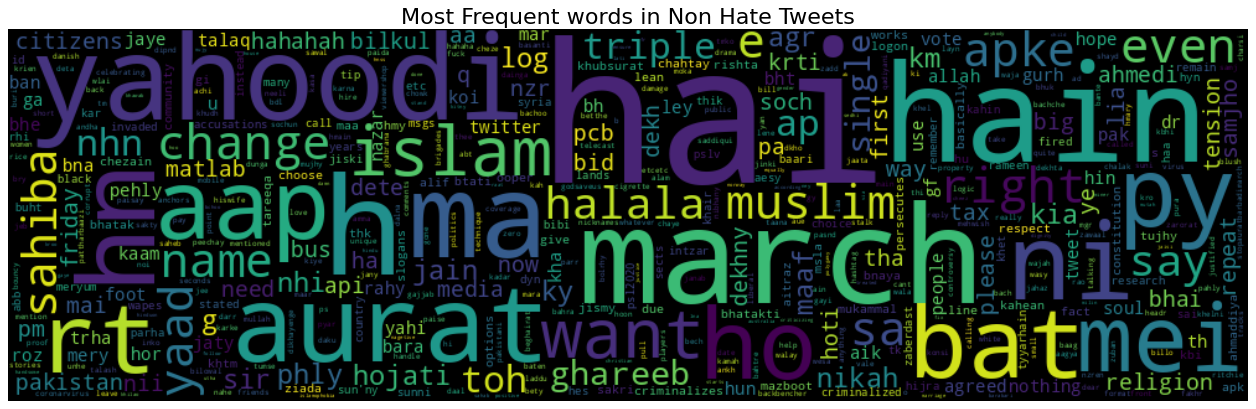

In [ ]:
text = ' '.join([word for word in non_hate_tweets['tweet']])
plt.figure(figsize = (20,15), facecolor= 'None')
wordcloud = WordCloud(max_words = 500, width = 1000, height = 300).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')

plt.axis('off')
plt.title('Most Frequent words in Non Hate Tweets', fontsize = 20)
plt.show()

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,2)).fit(tweet_df['tweet'])

In [ ]:

# feature_names = vect.get_feature_names()
# print("Number of features: {}\n".format(len(feature_names)))
# print("First 20 features:\n{}".format(feature_names[:20]))
feature_names = list(vect.vocabulary_.keys())
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))


Number of features: 3408

First 20 features:
['bhaunk', 'pagal', 'jaata', 'tak', 'bhaunk bhaunk', 'bhaunk pagal', 'pagal jaata', 'jaata tak', 'shivsaina', 'nam', 'mulla', 'saina', 'hijra', 'uddhav', 'thackeray', 'shivsaina nam', 'nam mulla', 'mulla saina', 'saina hijra', 'hijra uddhav']


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(ngram_range=(1, 3)).fit(tweet_df['tweet'])

In [ ]:
feature_names = list(vect.vocabulary_.keys())
print("Number of features: {}\n".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))


Number of features: 5176

First 20 features:
['bhaunk', 'pagal', 'jaata', 'tak', 'bhaunk bhaunk', 'bhaunk pagal', 'pagal jaata', 'jaata tak', 'bhaunk bhaunk pagal', 'bhaunk pagal jaata', 'pagal jaata tak', 'shivsaina', 'nam', 'mulla', 'saina', 'hijra', 'uddhav', 'thackeray', 'shivsaina nam', 'nam mulla']


In [ ]:
X = tweet_df['tweet']
Y = tweet_df['label']
X = vect.transform(X)

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [ ]:
X_train.shape

(160, 5176)

In [ ]:
y_train.shape

(160,)

In [ ]:
X_test.shape

(40, 5176)

In [ ]:
y_test.shape

(40,)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_predict = logreg.predict(X_test)
logreg_acc = accuracy_score(logreg_predict, y_test)
print("Test Accuracy : {:.2f}%".format(logreg_acc * 100))

Test Accuracy : 62.50%


In [ ]:
print("Confusion Matrix : \n",confusion_matrix(y_test, logreg_predict))
print("\n")
print("Classification Report : \n",classification_report(y_test, logreg_predict))

Confusion Matrix : 
 [[ 6 15]
 [ 0 19]]


Classification Report : 
                        precision    recall  f1-score   support

0 (Abusive/Offensive)       1.00      0.29      0.44        21
           1 (Normal)       0.56      1.00      0.72        19

             accuracy                           0.62        40
            macro avg       0.78      0.64      0.58        40
         weighted avg       0.79      0.62      0.57        40



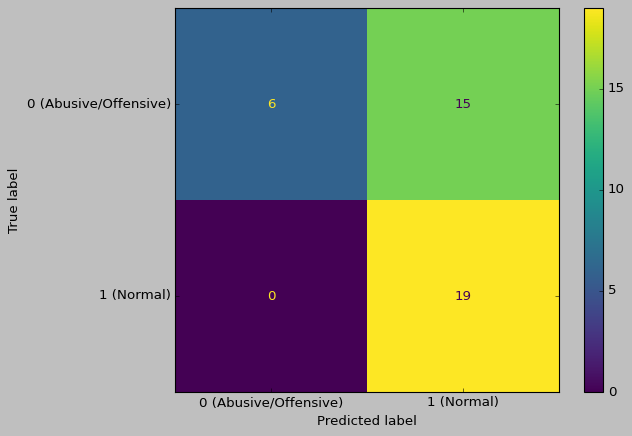

In [ ]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_predict, labels = logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logreg.classes_)
disp.plot()

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [ ]:
param_grid = {'C' : [100,10,1.0,0.1,0.01], 'solver' : ['newton-cg','lbfgs','liblinear']}
grid = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
grid.fit(X_train, y_train)
print("Best Cross validation score : {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best Cross validation score : 0.64
Best parameters:  {'C': 100, 'solver': 'newton-cg'}


In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test Accuracy : {:.2f}%".format(logreg_acc * 100))

Test Accuracy : 65.00%


In [ ]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 9 12]
 [ 2 17]]


                       precision    recall  f1-score   support

0 (Abusive/Offensive)       0.82      0.43      0.56        21
           1 (Normal)       0.59      0.89      0.71        19

             accuracy                           0.65        40
            macro avg       0.70      0.66      0.64        40
         weighted avg       0.71      0.65      0.63        40

